# Nationality Detection Model

**Import the Libraries**

In [20]:

import os
import pandas as pd
import numpy as np

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')



**Load CSVs + Validate Image Paths**

In [21]:
# Set the directory paths
train_img_dir = '/kaggle/input/fairface/fairface/train'
val_img_dir = '/kaggle/input/fairface/fairface/val'

# Load .CSV files
train_df = pd.read_csv('/kaggle/input/fairface/fairface/fairface_label_train.csv')
val_df = pd.read_csv('/kaggle/input/fairface/fairface/fairface_label_val.csv')

# Use only columns that we needed
train_df = train_df[['file', 'race']]
val_df = val_df[['file', 'race']]

# Add full paths of images 
train_df['file'] = train_df['file'].apply(lambda x: os.path.join(train_img_dir, os.path.basename(x)))
val_df['file'] = val_df['file'].apply(lambda x: os.path.join(val_img_dir, os.path.basename(x)))

# Check the paths of some images with lables
print("Train sample:\n", train_df.head())
print("Validation sample:\n", val_df.head())


print("Exists?", os.path.exists(train_df['file'].iloc[0]))


Train sample:
                                           file        race
0  /kaggle/input/fairface/fairface/train/1.jpg  East Asian
1  /kaggle/input/fairface/fairface/train/2.jpg      Indian
2  /kaggle/input/fairface/fairface/train/3.jpg       Black
3  /kaggle/input/fairface/fairface/train/4.jpg      Indian
4  /kaggle/input/fairface/fairface/train/5.jpg      Indian
Validation sample:
                                         file             race
0  /kaggle/input/fairface/fairface/val/1.jpg       East Asian
1  /kaggle/input/fairface/fairface/val/2.jpg       East Asian
2  /kaggle/input/fairface/fairface/val/3.jpg            White
3  /kaggle/input/fairface/fairface/val/4.jpg  Latino_Hispanic
4  /kaggle/input/fairface/fairface/val/5.jpg  Southeast Asian
Exists? True


In [22]:
import pandas as pd
import os

#Load the .CSV file
df = pd.read_csv("/kaggle/input/fairface/fairface/fairface_label_train.csv")

#Fix images path
def get_full_image_path(file_column_value):
    return os.path.join("/kaggle/input/fairface/fairface/train", os.path.basename(file_column_value))

df['img_path'] = df['file'].apply(get_full_image_path)

# Check paths validity
missing = [p for p in df['img_path'] if not os.path.exists(p)]
print(f" Valid image paths: {len(df) - len(missing)}")
print(f" Missing image paths: {len(missing)}")

#Rename to df_train for the consistency
df_train = df.copy()


 Valid image paths: 86744
 Missing image paths: 0


In [23]:
# get 8000 images per race class because of model train every type of nationality
balanced_df = df_train.groupby('race', group_keys=False).apply(lambda x: x.sample(8000, random_state=42)).reset_index(drop=True)

# Confirm counts of the labels
print(balanced_df['race'].value_counts())

race
Black              8000
East Asian         8000
Indian             8000
Latino_Hispanic    8000
Middle Eastern     8000
Southeast Asian    8000
White              8000
Name: count, dtype: int64


**Load + Preprocess Images and Labels**

In [24]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Set images size
img_size = 64

# Function to load and preprocess images using img_path 
def load_data(df):
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = row['img_path']  
        label = row['race']

        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # Normalization
            images.append(img)
            labels.append(label)
        else:
            print(f" Cannot read: {img_path}")

    return np.array(images), np.array(labels)

# Split the balanced data
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(balanced_df, test_size=0.1, stratify=balanced_df['race'], random_state=42)

# Load the images
X_train, y_train = load_data(train_df)
X_val, y_val = load_data(val_df)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_val_encoded = to_categorical(label_encoder.transform(y_val))

# Print and check the shape of the train set ensure about the label
print(" X_train shape:", X_train.shape)
print(" y_train shape:", y_train_encoded.shape)
print(" Classes:", label_encoder.classes_)


 X_train shape: (50400, 64, 64, 3)
 y_train shape: (50400, 7)
 Classes: ['Black' 'East Asian' 'Indian' 'Latino_Hispanic' 'Middle Eastern'
 'Southeast Asian' 'White']


**Visualizing the Dataset Images**

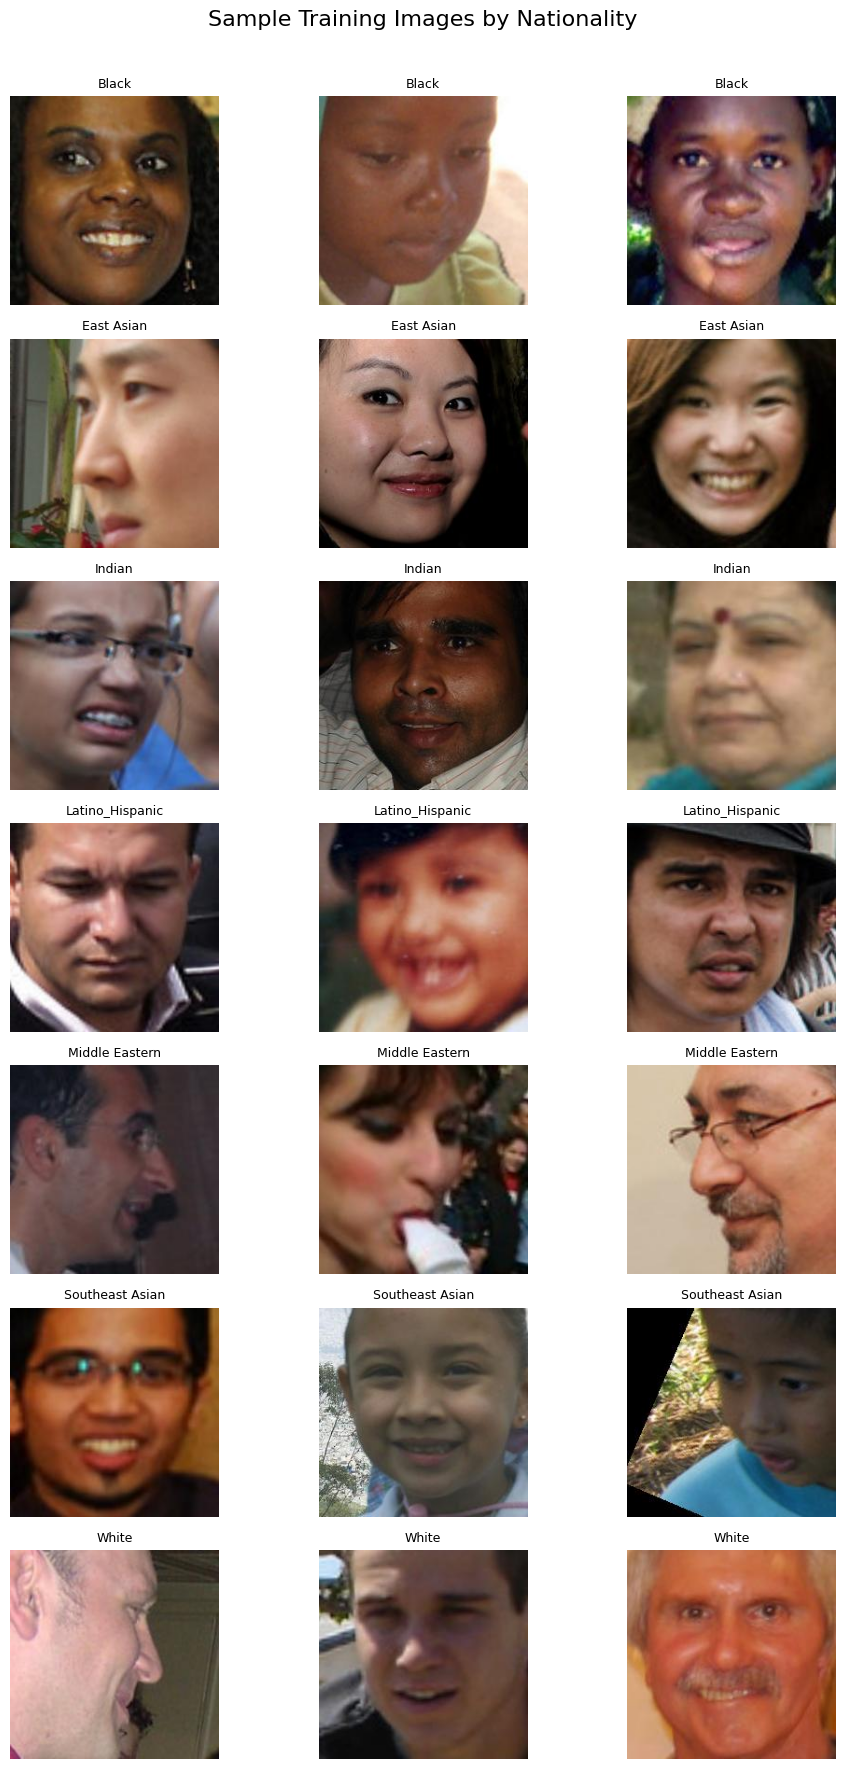

In [25]:
import matplotlib.pyplot as plt
import cv2
import random
import os

# Classes in order of encoded labels
race_classes = sorted(df_train['race'].unique())

# Create a 7x3 grid of sample images (3 images per class)
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10, 18))
fig.suptitle("Sample Training Images by Nationality", fontsize=16)
train_dir = "/kaggle/input/fairface/fairface/train"


for i, race in enumerate(race_classes):
    # Get 3 random file names for this race class
    sample_rows = df_train[df_train['race'] == race].sample(3, random_state=42)
    for j, filename in enumerate(sample_rows['file'].values):
        img_path = os.path.join(train_dir, os.path.basename(filename))
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{race}", fontsize=9)
        else:
            axes[i, j].text(0.5, 0.5, "Image not found", ha='center', va='center')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


**Build the CNN Model**

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 race classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,999 (2.61 MB)

 Trainable params: 684,551 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

**Compile the Model**

In [27]:
# Compile the CNN model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("done")

done


In [28]:
#  Encode race labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['race'])
y_val_encoded = label_encoder.transform(val_df['race'])

# One-hot encode the integer labels
y_train = to_categorical(y_train_encoded)
y_val = to_categorical(y_val_encoded)

#  Confirm shapes again
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("Encoded classes:", label_encoder.classes_)


y_train shape: (50400, 7)
y_val shape: (5600, 7)
Encoded classes: ['Black' 'East Asian' 'Indian' 'Latino_Hispanic' 'Middle Eastern'
 'Southeast Asian' 'White']


# Train the Model with Callbacks

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the CNN model using the CNN layers(Sequential, Dense , Flatten,MaxPooling2D, Dropout)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 Nationality classes
])

# Compile our model 
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train our model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)
print("done")

Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.2012 - loss: 1.8992 - val_accuracy: 0.3388 - val_loss: 1.7242
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3387 - loss: 1.6984 - val_accuracy: 0.3925 - val_loss: 1.5883
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3865 - loss: 1.5865 - val_accuracy: 0.4266 - val_loss: 1.5100
Epoch 4/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4182 - loss: 1.5140 - val_accuracy: 0.4364 - val_loss: 1.4486
Epoch 5/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4316 - loss: 1.4689 - val_accuracy: 0.4552 - val_loss: 1.4161
Epoch 6/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4543 - loss: 1.4191 - val_accuracy: 0.4696 - val_loss: 1.3769
Epoch 7/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4705 - loss: 1.3825 - val_accuracy: 0.4761 - val_loss: 1.3523
Epoch 8/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4791 - loss: 1.3535 - val_accuracy: 

**Plot Training History**

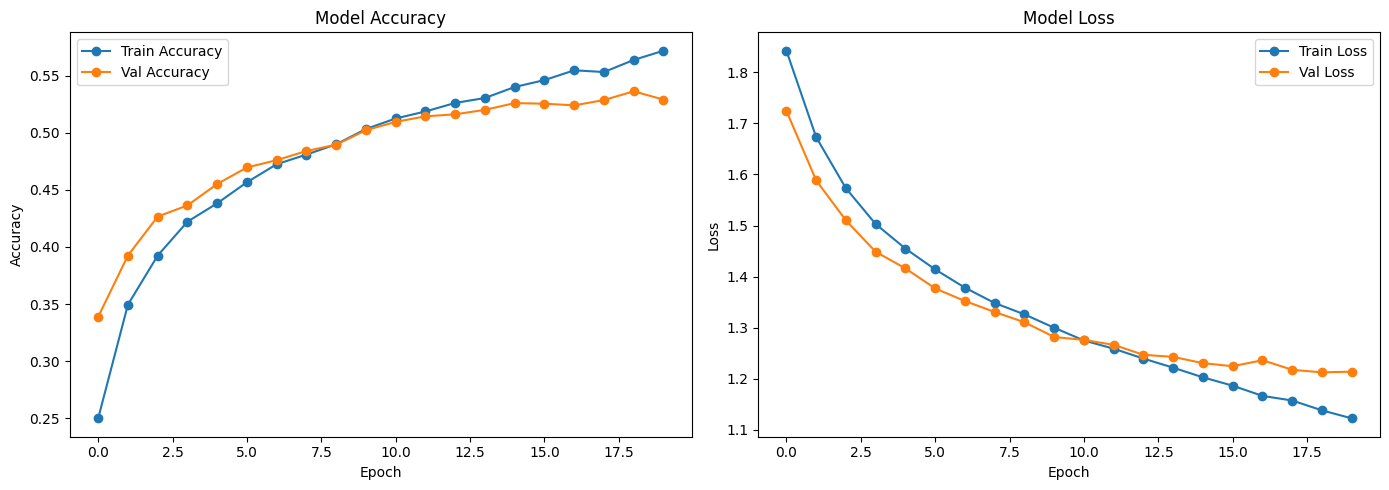

In [30]:
#  Plot accuracy and loss of the trained model
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Test the Model Using the Beyond Dataset Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
/kaggle/input/modelcheck/ea.jpg → Predicted: Middle Eastern (0.71)


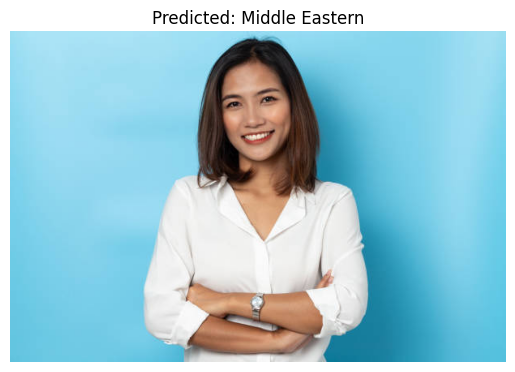

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
/kaggle/input/modelcheck/ind.webp → Predicted: Black (0.35)


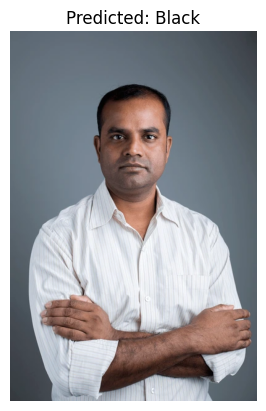

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
/kaggle/input/modelcheck/me.jpeg → Predicted: White (0.39)


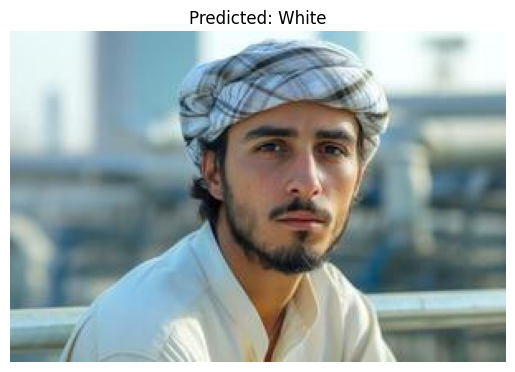

In [31]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define label mapping
race_labels = ['White', 'Black', 'Latino_Hispanic', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern']

# Function to preprocess a single image
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error reading {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    return np.expand_dims(img, axis=0)

# Predict function
def predict_image(img_path):
    preprocessed = preprocess_image(img_path)
    if preprocessed is not None:
        pred = model.predict(preprocessed)
        predicted_class = race_labels[np.argmax(pred)]
        confidence = np.max(pred)
        print(f"{img_path} → Predicted: {predicted_class} ({confidence:.2f})")
        # Optional: Show image
        plt.imshow(cv2.imread(img_path)[..., ::-1])
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

# Predict on uploaded test images
predict_image("/kaggle/input/modelcheck/ea.jpg")
predict_image("/kaggle/input/modelcheck/ind.webp")
predict_image("/kaggle/input/modelcheck/me.jpeg")


In [17]:
# Save the model in Keras format (.keras)
model.save("nationality_model.keras")
print("done")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
done


Saved files: ['.virtual_documents', 'nationality_model.keras']
